In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
from pathlib import Path

# Paths
TRAIN_PATH = Path("exoplanet-ai-data/exoTrain.csv")   # or .xlsx
TEST_PATH = Path("exoplanet-ai-data/exoTest-nokey-trunc.csv")  # or .xlsx
MODEL_PATH = Path("exoplanet_model.pkl")


In [10]:
def load_data(path: Path):
    if path.suffix == ".csv":
        df = pd.read_csv(path)
    elif path.suffix in [".xls", ".xlsx"]:
        df = pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file format: {path.suffix}")

    # Rename first column to LABEL
    df.rename(columns={df.columns[0]: "LABEL"}, inplace=True)

    # Convert labels: 2 = planet (1), 1 = not planet (0)
    df["LABEL"] = (df["LABEL"] == 2).astype(int)
    return df


In [12]:
if MODEL_PATH.exists():
    print("🔍 Loading existing model...")
    model = joblib.load(MODEL_PATH)
else:
    print("📂 Loading training data...")
    train = load_data(TRAIN_PATH)
    print("📂 Loading test data...")
    test = load_data(TEST_PATH)

    X_train, y_train = train.drop("LABEL", axis=1), train["LABEL"]
    X_test, y_test = test.drop("LABEL", axis=1), test["LABEL"]

    print("🤖 Training RandomForest model...")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Training complete. Test Accuracy: {acc*100:.2f}%")

    # Save model
    MODEL_PATH.parent.mkdir(exist_ok=True)
    joblib.dump(model, MODEL_PATH)
    print(f"💾 Model saved to {MODEL_PATH}")


📂 Loading training data...
📂 Loading test data...
🤖 Training RandomForest model...
✅ Training complete. Test Accuracy: 99.82%
💾 Model saved to exoplanet-ai-data\exoplanet_model.pkl


In [13]:
print("📂 Loading test data for predictions...")
test = pd.read_csv(TEST_PATH)
test.rename(columns={test.columns[0]: "LABEL"}, inplace=True)
X_test = test.drop("LABEL", axis=1)


📂 Loading test data for predictions...


In [14]:
print("✅ First 5 Predictions:", model.predict(X_test[:5]))



✅ First 5 Predictions: [0 0 0 0 0]


In [15]:
preds = model.predict(X_test)

planet_count = (preds == 1).sum()
not_planet_count = (preds == 0).sum()

print("🔎 Prediction Summary:")
print(f"   🌍 Planets Detected: {planet_count}")
print(f"   ❌ Not Planets: {not_planet_count}")
print(f"   📊 Total Samples: {len(preds)}")


🔎 Prediction Summary:
   🌍 Planets Detected: 0
   ❌ Not Planets: 570
   📊 Total Samples: 570


In [16]:
true_planets = (test["LABEL"] == 1).sum()
true_not_planets = (test["LABEL"] == 0).sum()

print("📊 True Label Distribution in Test Data:")
print(f"   🌍 Planets (LABEL=1): {true_planets}")
print(f"   ❌ Not Planets (LABEL=0): {true_not_planets}")


📊 True Label Distribution in Test Data:
   🌍 Planets (LABEL=1): 1
   ❌ Not Planets (LABEL=0): 0


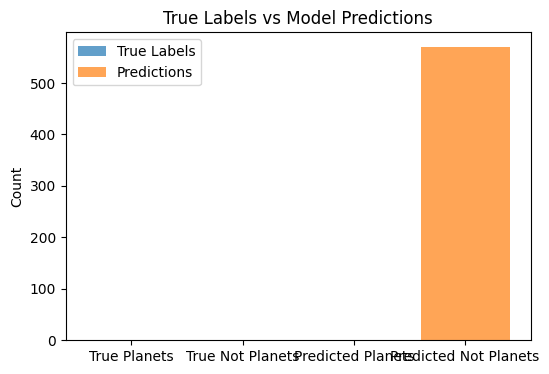

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(["True Planets","True Not Planets"], [true_planets, true_not_planets], alpha=0.7, label="True Labels")
plt.bar(["Predicted Planets","Predicted Not Planets"], [planet_count, not_planet_count], alpha=0.7, label="Predictions")
plt.ylabel("Count")
plt.title("True Labels vs Model Predictions")
plt.legend()
plt.show()


New one

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np

# Load the Kepler Cumulative Data, skipping the initial header/comment rows
file_name = "exoplanet-ai-data/cumulative_2025.10.03_22.54.46.csv"
df = pd.read_csv(file_name, skiprows=53)

# Define the target variable
TARGET = 'koi_disposition'

In [20]:
# Select columns to keep (based on physical parameters and flags)
columns_to_keep = [
    TARGET, 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration',
    'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr',
    'koi_steff', 'koi_slogg', 'koi_srad', 'koi_kepmag', 'koi_score',
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'
]

# Create the feature DataFrame
df_features = df[columns_to_keep].copy()

# Drop rows where the target variable is missing (though in this dataset, it's usually complete)
df_features.dropna(subset=[TARGET], inplace=True)

In [21]:
# Identify continuous and categorical features
numerical_features = df_features.select_dtypes(include=np.number).columns.tolist()
# Remove the binary flag columns from numerical imputation
binary_flags = ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']
numerical_features = [col for col in numerical_features if col not in binary_flags]

# Apply Median Imputation to numerical features
imputer = SimpleImputer(strategy='median')
df_features[numerical_features] = imputer.fit_transform(df_features[numerical_features])

# Verify that there are no remaining NaNs in the feature set (excluding the target)
print("Number of remaining NaN values per column after imputation:")
print(df_features.drop(columns=[TARGET]).isnull().sum().sort_values(ascending=False).head())

Number of remaining NaN values per column after imputation:
koi_period      0
koi_time0bk     0
koi_impact      0
koi_duration    0
koi_depth       0
dtype: int64


In [22]:
# Initialize LabelEncoder for the target variable
le = LabelEncoder()
df_features['disposition_encoded'] = le.fit_transform(df_features[TARGET])

# Map the original labels to the encoded values for reference
# This is crucial for interpreting the model's output later
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nTarget Label Encoding:")
print(label_mapping)
# CONFIRMED: 0, CANDIDATE: 1, FALSE POSITIVE: 2 (The exact number depends on alphabetical order)

# Define features (X) and target (y)
X = df_features.drop(columns=[TARGET, 'disposition_encoded'])
y = df_features['disposition_encoded']

# Split the data into 80% training and 20% testing sets using stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensures equal distribution of classes in train/test sets
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Target Label Encoding:
{'CANDIDATE': np.int64(0), 'CONFIRMED': np.int64(1), 'FALSE POSITIVE': np.int64(2)}

Training set size: 7651
Testing set size: 1913


Model Accuracy on Test Set: 0.9279

--- Classification Report ---
                precision    recall  f1-score   support

     CANDIDATE       0.83      0.84      0.83       396
     CONFIRMED       0.88      0.90      0.89       549
FALSE POSITIVE       1.00      0.98      0.99       968

      accuracy                           0.93      1913
     macro avg       0.90      0.91      0.90      1913
  weighted avg       0.93      0.93      0.93      1913



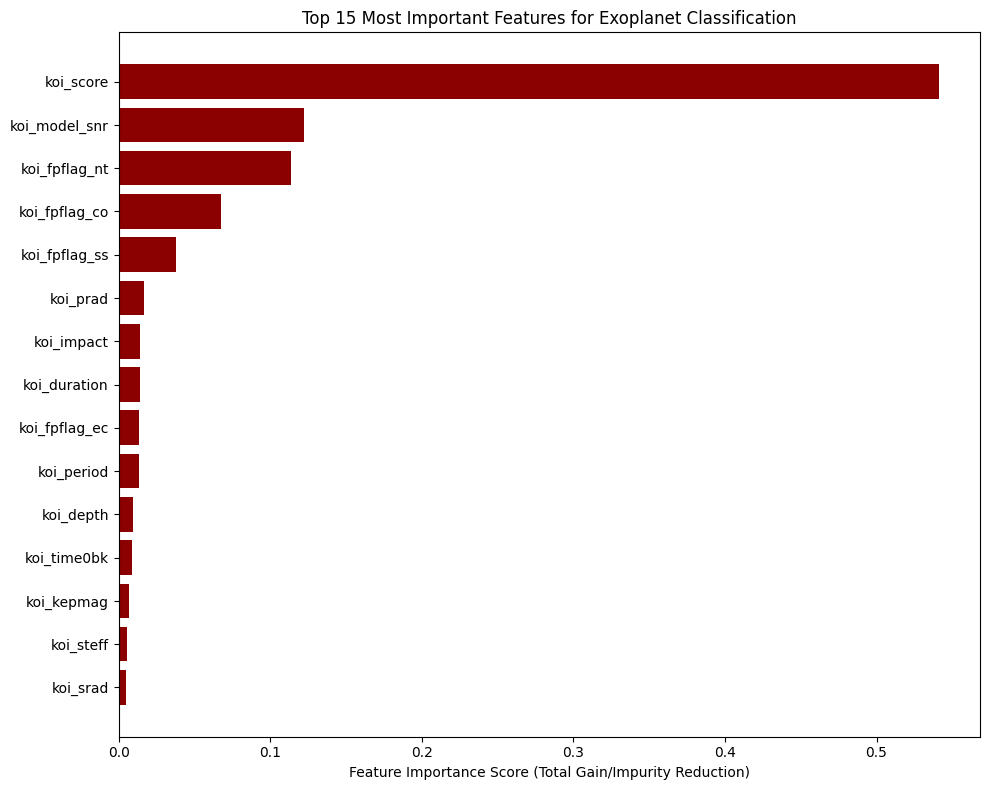

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt

# --- STEP 1: Data Preparation and Preprocessing ---

# Load the Kepler Cumulative Data, skipping the initial header/comment rows
file_name = "exoplanet-ai-data/cumulative_2025.10.03_22.54.46.csv"
df = pd.read_csv(file_name, skiprows=53)

# Define the target variable
TARGET = 'koi_disposition'

# Select core features (planetary, stellar, and flags)
columns_to_keep = [
    TARGET, 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration',
    'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr',
    'koi_steff', 'koi_slogg', 'koi_srad', 'koi_kepmag', 'koi_score',
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'
]
df_features = df[columns_to_keep].copy()
df_features.dropna(subset=[TARGET], inplace=True)

# Identify numerical features for median imputation (excluding binary flags)
numerical_features = df_features.select_dtypes(include=np.number).columns.tolist()
binary_flags = ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']
numerical_features = [col for col in numerical_features if col not in binary_flags]

# Apply Median Imputation to handle missing values
imputer = SimpleImputer(strategy='median')
df_features[numerical_features] = imputer.fit_transform(df_features[numerical_features])

# Encoding the Target Variable (CANDIDATE: 0, CONFIRMED: 1, FALSE POSITIVE: 2)
le = LabelEncoder()
df_features['disposition_encoded'] = le.fit_transform(df_features[TARGET])
class_names = le.classes_

# Define features (X) and target (y)
X = df_features.drop(columns=[TARGET, 'disposition_encoded'])
y = df_features['disposition_encoded']

# Split the data into 80% training and 20% testing sets using stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# --- STEP 2: Model Training and Evaluation ---

# Initialize the GradientBoosting Classifier
gbc_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train the model
gbc_model.fit(X_train, y_train)

# Predict on the test data
y_pred = gbc_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Set: {accuracy:.4f}")

# Generate detailed classification report
report = classification_report(y_test, y_pred, target_names=class_names)
print("\n--- Classification Report ---")
print(report)

# Feature Importance Analysis for visualization
importance = gbc_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plotting the top features
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15], color='darkred')
plt.xlabel('Feature Importance Score (Total Gain/Impurity Reduction)')
plt.title('Top 15 Most Important Features for Exoplanet Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_plot.png')

In [26]:
import pickle

# --- Saving the Trained Model and Preprocessing Objects ---

# 1. Save the trained Gradient Boosting Classifier model
with open('gbc_model.pkl', 'wb') as file:
    pickle.dump(gbc_model, file)

print("Trained GBC Model successfully saved as 'gbc_model.pkl'")

# 2. Save the fitted SimpleImputer object
# This is crucial because the web app needs to apply the exact same median imputation
# to any new user data before prediction.
with open('imputer.pkl', 'wb') as file:
    pickle.dump(imputer, file)

print("Fitted Imputer successfully saved as 'imputer.pkl'")

# 3. Save the list of feature columns in the correct order
# The prediction function must receive features in this exact order.
feature_cols = list(X_train.columns)
with open('feature_cols.pkl', 'wb') as file:
    pickle.dump(feature_cols, file)
    
print("Feature column list successfully saved as 'feature_cols.pkl'")

print("\nAll necessary model files are saved and ready for deployment in the Streamlit app.")

Trained GBC Model successfully saved as 'gbc_model.pkl'
Fitted Imputer successfully saved as 'imputer.pkl'
Feature column list successfully saved as 'feature_cols.pkl'

All necessary model files are saved and ready for deployment in the Streamlit app.


2025-10-04 16:23:07.121 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 16:23:07.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 16:23:07.149 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 16:23:07.152 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 16:23:07.158 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 16:23:07.166 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 16:23:07.168 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-04 16:23:07.170 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar